# SimNet Training for Balancing Robot

This notebook trains a SimNet model using both physics simulation data and real-world data.

In [1]:
import sys
sys.path.append('..')

import torch
import numpy as np
from pathlib import Path
import json
import yaml
import glob
from matplotlib import pyplot as plt

from src.balancing_robot.models import SimNet
from src.balancing_robot.environment import BalancerEnv
from src.balancing_robot.training import SimNetTrainer
from src.balancing_robot.visualization import plot_predictions_comparison

## Load Configuration

In [2]:
# Load configurations
with open('../configs/simnet_config.yaml', 'r') as f:
    simnet_config = yaml.safe_load(f)

with open('../configs/env_config.yaml', 'r') as f:
    env_config = yaml.safe_load(f)

# Create directories
log_dir = Path('logs/simnet_training')
log_dir.mkdir(parents=True, exist_ok=True)

## Initialize Models and Environment

In [3]:
# Set random seeds
torch.manual_seed(simnet_config['data_collection']['random_seed'])
np.random.seed(simnet_config['data_collection']['random_seed'])

# Create environment for physics data
env = BalancerEnv(config_path='../configs/env_config.yaml')

# Initialize trainer with config
trainer = SimNetTrainer(
    env=env,
    config_path='../configs/simnet_config.yaml'
)

c:\Users\eyalp\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
c:\Users\eyalp\AppData\Local\Programs\Python\Python310\lib\site-packages\gymnasium\spaces\box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


## Collect and Process Physics Data

In [4]:
# Collect physics simulation data
train_data, val_data = trainer.collect_physics_data()

print(f"Collected {len(train_data['states'])} training samples")
print(f"Collected {len(val_data['states'])} validation samples")

Collected 811782 training samples
Collected 202945 validation samples


## Train on Physics Data

In [5]:
# Train on physics data
physics_history = trainer.train(
    train_data=train_data,
    val_data=val_data,
    is_finetuning=False,
    log_dir=log_dir / 'physics'
)

Epoch 1/50 - Train Loss: 5.807177 - Val Loss: 3.615798
Epoch 2/50 - Train Loss: 2.686083 - Val Loss: 1.999711
Epoch 3/50 - Train Loss: 1.489669 - Val Loss: 1.106722
Epoch 4/50 - Train Loss: 0.802056 - Val Loss: 0.578221
Epoch 5/50 - Train Loss: 0.414445 - Val Loss: 0.295866
Epoch 6/50 - Train Loss: 0.208222 - Val Loss: 0.148466
Epoch 7/50 - Train Loss: 0.104180 - Val Loss: 0.075829
Epoch 8/50 - Train Loss: 0.053012 - Val Loss: 0.039887
Epoch 9/50 - Train Loss: 0.028339 - Val Loss: 0.022520
Epoch 10/50 - Train Loss: 0.016599 - Val Loss: 0.014192
Epoch 11/50 - Train Loss: 0.011115 - Val Loss: 0.010206
Epoch 12/50 - Train Loss: 0.008444 - Val Loss: 0.008127
Epoch 13/50 - Train Loss: 0.007006 - Val Loss: 0.006915
Epoch 14/50 - Train Loss: 0.006143 - Val Loss: 0.006149
Epoch 15/50 - Train Loss: 0.005585 - Val Loss: 0.005636
Epoch 16/50 - Train Loss: 0.005194 - Val Loss: 0.005259
Epoch 17/50 - Train Loss: 0.004900 - Val Loss: 0.004973
Epoch 18/50 - Train Loss: 0.004669 - Val Loss: 0.004746
E

In [6]:
# Save physics trained SimNet
torch.save({
    'state_dict': trainer.simnet.state_dict(),
    'physics_history': physics_history,
    'config': simnet_config,
    'metadata': {
        'state_dim': env.observation_space.shape[0],
        'action_dim': env.action_space.shape[0],
        'hidden_dims': simnet_config['model']['hidden_dims']
    }
}, log_dir / 'simnet_physics_final.pt')

simnet_physics = SimNet(
    state_dim=env.observation_space.shape[0],
    action_dim=env.action_space.shape[0],
    hidden_dims=simnet_config['model']['hidden_dims']
)
simnet_physics.load_state_dict(torch.load(log_dir / 'simnet_physics_final.pt')['state_dict'])

<All keys matched successfully>

## Load and Process Real-World Data

In [7]:
# Find all files that start with robot_logs and end with .json
log_files = glob.glob('../data/robot_logs*.json')
print(f"Found {len(log_files)} log files: {log_files}")

# Initialize empty list to store all episodes
all_episodes = []

# Load and append data from each file
for log_file in log_files:
    with open(log_file, 'r') as f:
        log_data = json.load(f)
        # Append episodes from this file
        all_episodes.extend(log_data['episodes'])
        print(f"Loaded {len(log_data['episodes'])} episodes from {log_file}")

# Process combined data
real_train_data, real_val_data = trainer.process_real_data(all_episodes)
print(f"Processed {len(real_train_data['states'])} real training samples")
print(f"Processed {len(real_val_data['states'])} real validation samples")

Found 2 log files: ['../data\\robot_logs_20250308_205032_no_motor.json', '../data\\robot_logs_20250308_205436_with_motor.json']
Loaded 40 episodes from ../data\robot_logs_20250308_205032_no_motor.json
Loaded 14 episodes from ../data\robot_logs_20250308_205436_with_motor.json
Processed 3265 real training samples
Processed 816 real validation samples


## Fine-tune on Real Data

In [8]:
# Fine-tune on real data
real_history = trainer.train(
    train_data=real_train_data,
    val_data=real_val_data,
    is_finetuning=True,
    log_dir=log_dir / 'real'
)

Epoch 1/20 - Train Loss: 1.897775 - Val Loss: 1.766343
Epoch 2/20 - Train Loss: 1.543849 - Val Loss: 1.619060
Epoch 3/20 - Train Loss: 1.457818 - Val Loss: 1.599313
Epoch 4/20 - Train Loss: 1.437118 - Val Loss: 1.599258
Epoch 00055: reducing learning rate of group 0 to 5.0000e-05.
Epoch 5/20 - Train Loss: 1.427866 - Val Loss: 1.597988
Epoch 6/20 - Train Loss: 1.421967 - Val Loss: 1.596926
Epoch 7/20 - Train Loss: 1.419157 - Val Loss: 1.595803
Epoch 8/20 - Train Loss: 1.416642 - Val Loss: 1.594773
Epoch 9/20 - Train Loss: 1.414358 - Val Loss: 1.593800
Epoch 00060: reducing learning rate of group 0 to 2.5000e-05.
Epoch 10/20 - Train Loss: 1.412318 - Val Loss: 1.592816
Epoch 11/20 - Train Loss: 1.410653 - Val Loss: 1.592249
Epoch 12/20 - Train Loss: 1.409774 - Val Loss: 1.591700
Epoch 13/20 - Train Loss: 1.408927 - Val Loss: 1.591182
Epoch 14/20 - Train Loss: 1.408111 - Val Loss: 1.590691
Epoch 00065: reducing learning rate of group 0 to 1.2500e-05.
Epoch 15/20 - Train Loss: 1.407322 - Va

## Analyze Predictions

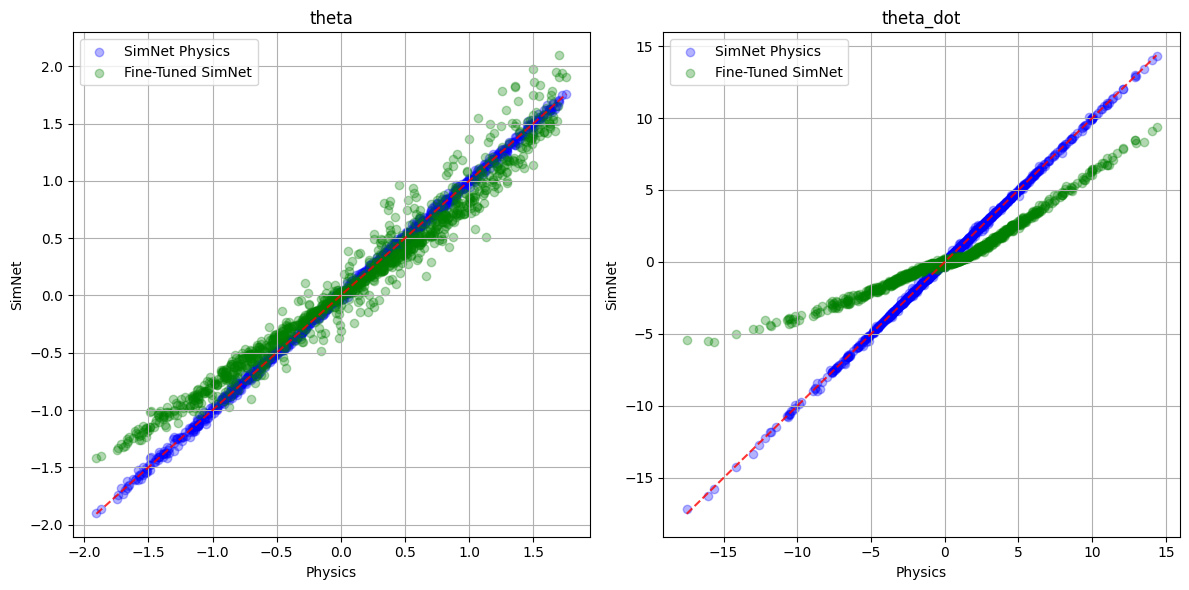

In [9]:

test_states = val_data["states"][:1000]
test_actions = val_data["actions"][:1000]
physics_preds = val_data["next_states"][:1000]  # The actual next states from the physics data

# Get SimNet predictions
simnet_preds = []
simnet_physics_preds = []
for s, a in zip(test_states, test_actions):
    s_tensor = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
    a_tensor = torch.tensor(a, dtype=torch.float32).unsqueeze(0)
    pred_next = trainer.simnet(s_tensor, a_tensor).detach().numpy()[0]
    simnet_preds.append(pred_next)
    pred_next_physics = simnet_physics(s_tensor, a_tensor).detach().numpy()[0]
    simnet_physics_preds.append(pred_next_physics)
simnet_preds = np.array(simnet_preds)
simnet_physics_preds = np.array(simnet_physics_preds)

# Plot comparison (assuming your plot function looks something like this)
fig = plot_predictions_comparison(
    physics_preds=physics_preds,   # ground-truth next states
    simnet_preds=simnet_preds,     # network-predicted next states
    simnet_physics_preds=simnet_physics_preds,  # network-predicted next states using simnet physics model
    save_path=log_dir / "prediction_comparison.png"
)
plt.show()


## Save Final Model

In [10]:
# Save trained SimNet
torch.save({
    'state_dict': trainer.simnet.state_dict(),
    'physics_history': physics_history,
    'real_history': real_history,
    'config': simnet_config,
    'metadata': {
        'state_dim': env.observation_space.shape[0],
        'action_dim': env.action_space.shape[0],
        'hidden_dims': simnet_config['model']['hidden_dims']
    }
}, log_dir / 'simnet_final.pt')
